
Hexagonal grid(hexgrids) are an useful tool when one is performing spatial analysis in GIS. It is opposed to the ubiquitous square-patterned type of data (Raster, netCDF, etc.), which is more straightforward as the data can be rendered within an image format.

Python is a relatively new tool, allowing the GIS analyst to leverage the power of Python's numerous libraries. These opensource libraries provide numerous tools for scientific calculation, such as statistical [Scikit learn] and spatial analysis library [PySAL](http://pysal.org/pysal/).
As I aim at using the [Tobler](https://pysal.org/notebooks/model/tobler/intro.html) package, which is part of the [PySAL](http://pysal.org/pysal/) library, I would favor doing any calculations of [spatial interpolation](https://docs.qgis.org/2.18/en/docs/gentle_gis_introduction/spatial_analysis_interpolation.html) in a hexgrid pattern. 

Hexgrid pattern offers indeed the same amount of contact length for each of its neighbors, which is not the case with your default pixels. It is then up to the operator to pick a law that is mitigating the influence of corner pixels(nearest neighbor, bilinear interpolation, trilinear interpolation) on the calculation. Since a hexgrid cell is contacting its neighbouring cells by the same amount, calculation results are less tricky to make sense of. Also, there won't be any error generated by decreasing the hexgrid mesh resolution, lowering its cell count in general.
Furthermore, I expect hexgrid to be more robust dealilng with datasources of different resolution for interpolation calculations.

While the [h3fy function](https://pysal.org/tobler/notebooks/census_to_hexgrid.html) from Tobler's package is providing a quick way to creating a hex grid atop of geographical data, I achieved the same functionnality using GeoPandas and [Shapely](https://shapely.readthedocs.io/en/stable/index.html)'s [Voronoi Polygons](https://shapely.readthedocs.io/en/stable/reference/shapely.voronoi_polygons.html) method.

This work is meant to find out pyhton syntax useful to gather data from a PostGIS Database to perform treatment using Python's aforementionned libraries.

Any feedback is appreciated.


# Hexgrid on GIS data

## Setup



In [85]:
import geopandas as gpd
import shapely as shp
import pandas as pd
import matplotlib.pyplot as plt

We're supplying the [database URL](https://docs.sqlalchemy.org/en/20/core/engines.html#database-urls) so wa can setup [SQL Alchemy](https://docs.sqlalchemy.org/en/20/index.html)'s engine. Here, we're using [BD_Topo®](https://geoservices.ign.fr/bdtopo) data from France's IGN®, which is copied on a localhost database for convenience. We could use ["Département 34 - Hérault"](https://geoservices.ign.fr/bdtopo#telechargementshpdept) in particular.
We'll use later on France's official boundaries, with the [Admin Express](https://geoservices.ign.fr/adminexpress) dataset. But I've been importing a dataset from IGN's BD Topo Dataset, which is drawn after the former layer.

In [86]:
layer = gpd.read_file('periphereies/periphereies.shp')

### Of hexgrids

The *a* parameter is the distance separating the centroids of each hex cell. It's our resolution and it's set in the map's units (generally, meters). We're building our hex cells off of their centroid. Hence we are introducing the height *h* betwenn rows so that we'll eventually have an equiditant length between the points we're picking. $$h = \sqrt{a^2 - (a/2)^2} $$

In [87]:
a = 50000 # en mètres !

h = (a**2 - (a/2)**2)**(1/2)

### Mesh constructing with points

Let such a mesh happen within our considered area of interest. We'll define its *bounding box*. Our point mesh is drawn along the units of our Coordinate Reference System (**CRS**). 
First, we're calling GeoPanda's [total_bounds](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html) function, and we're defining our min and max values accordingly.

In [88]:
areaofinterest = layer.total_bounds 
x_min, y_min, x_max, y_max = [areaofinterest[m] for m in range(4)]

In [89]:
buffer_dist = 2*a

We'll implement two indexes, one referencing the position along the x axis, the other the position along the y axis. We'll later pick one out of two points of the mesh we're creating using these.

In [90]:
meshpoints_x = []
meshpoints_y = []
id_x =[]
id_y =[]
y_shift = y_min - h- buffer_dist
idy = 0
idx = 0
while y_shift < y_max + 2*h + buffer_dist:
    x_shift = x_min - (3/2)*a - buffer_dist
    while x_shift < x_max + (3/2)*a + buffer_dist:
        meshpoints_x.append(x_shift)
        meshpoints_y.append(y_shift)
        id_x.append(idx)
        id_y.append(idy)
        x_shift += a/2
        idx += 1
    idy += 1
    idx = 0  # reset the counter along the X axis
    y_shift += h
mesh_df = pd.DataFrame(data={'idx':id_x, 'idy':id_y, 'big_X':meshpoints_x, 'big_Y':meshpoints_y})   # gathering the lists' values in a Panda's DataFrame
mesh_df["geometry"]  = mesh_df.apply(lambda row: shp.Point(row.big_X, row.big_Y), axis=1)           # geometry creation
mesh_gdf = gpd.GeoDataFrame(mesh_df, geometry=mesh_df['geometry'], crs=layer.crs)                   # fitting the geometry creation along with associated data in a DataFrame
# mesh_gdf  # TEST

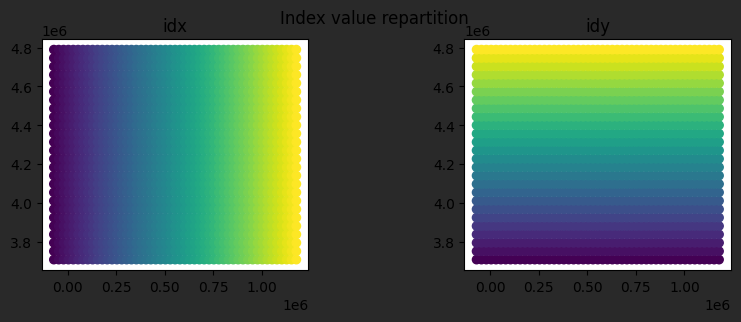

In [91]:
# TEST are my indexes behaving the way they're expected to
columns = ['idx', 'idy']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3), facecolor=(0.16,0.16,0.16))
[mesh_gdf.plot(ax=axes[i], column=columns[i]) for i in range(0,2)]   # comprehension list
[axes[i].set_title('{}'.format(columns[i]))for i in range(0,2)]      # comprehension list
fig.suptitle('Index value repartition');

I expected idx values to continuously vary along the x axis, while remaining the same from row to row. Meanwhile, I expected idy to behave the other way around. Hence I'm satisfied with the results.

Also, take a notice at the density of points in the GeoDataFrame.

### Equidistant point mesh

I'm picking point which idx index is even *and* idy index is even *as well as* (***or*** status) odd idx's **and** odd idy's.

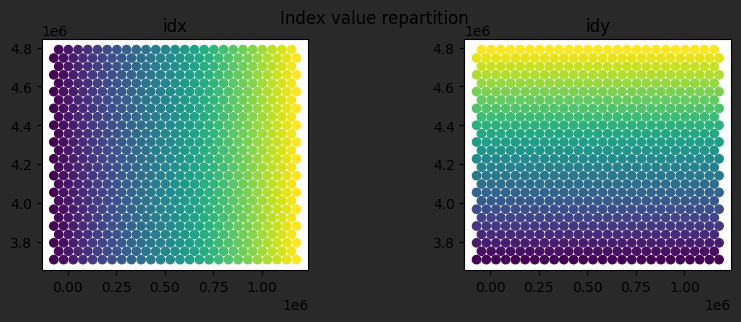

In [92]:
# evens = mesh_gdf[(mesh_gdf['idy'] % 2 == 0)&(mesh_gdf['idx'] % 2 == 0)] # TEST
oddsandevens = mesh_gdf[(mesh_gdf['idy'] % 2 == 0)&(mesh_gdf['idx'] % 2 == 0) | (mesh_gdf['idy'] % 2 == 1)&(mesh_gdf['idx'] % 2 == 1)].copy()

columns = ['idx', 'idy']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3), facecolor=(0.16,0.16,0.16))
[oddsandevens.plot(ax=axes[i], column=columns[i]) for i in range(0,2)]
[axes[i].set_title('{}'.format(columns[i])) for i in range(0,2)]
fig.suptitle('Index value repartition');

### Selection of useful points

In [93]:
# calclating the buffer
buffer = layer.buffer(buffer_dist).unary_union  # seems more optimized than buffer = layer.unary_union.buffer(2*a)
layer_buffer = gpd.GeoDataFrame(geometry=[buffer], crs=layer.crs)
# layer_buffer  # TEST

# selection by localisation
tri = gpd.sjoin(oddsandevens,layer_buffer, predicate='intersects', how='inner')
tri.drop(columns='index_right', inplace=True)  #grooming

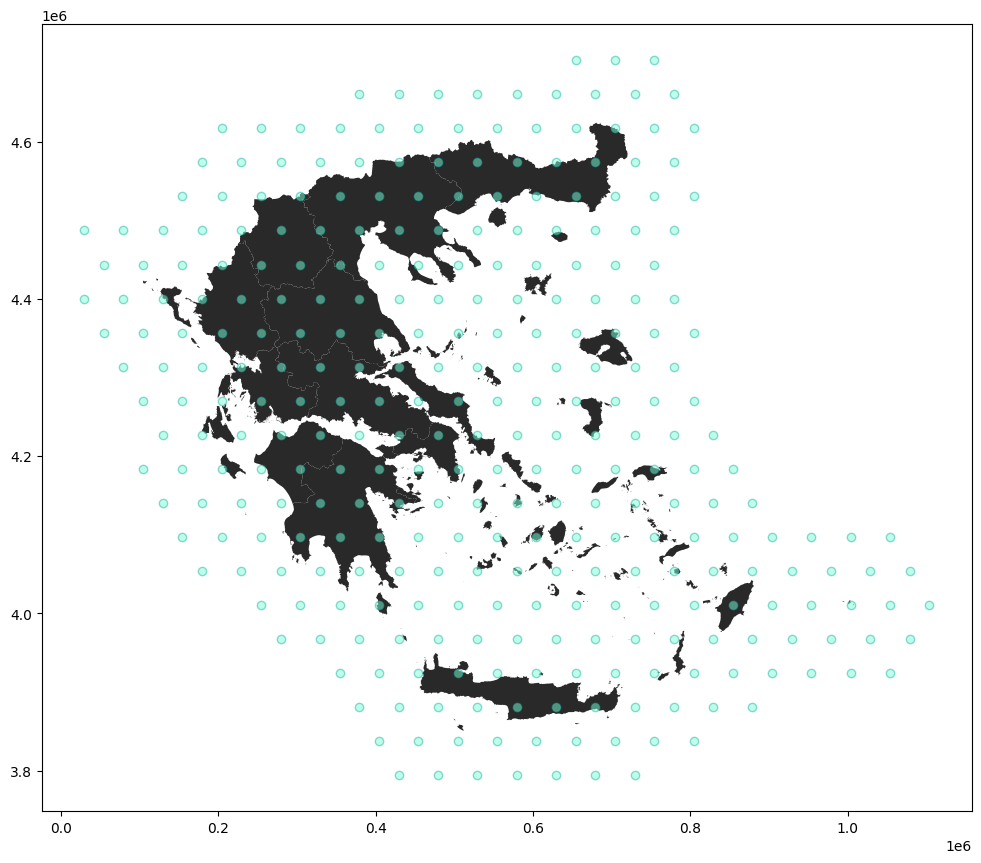

In [94]:
basemap = layer.plot(figsize=(12,12), facecolor=(0.16,0.16,0.16))
tri.plot(ax=basemap, color='aquamarine', edgecolor='lightseagreen', alpha=0.5);

## Voronois

We're going from a geometrycollection to gettin a full-featured Pandas GeoDataFrame

### Voronoi Creation

Now is the time to use [Shapely](https://shapely.readthedocs.io/en/stable/index.html)'s [Voronoi Polygons](https://shapely.readthedocs.io/en/stable/reference/shapely.voronoi_polygons.html) method. Shapely is supplied when the GeoPandas package is installing.


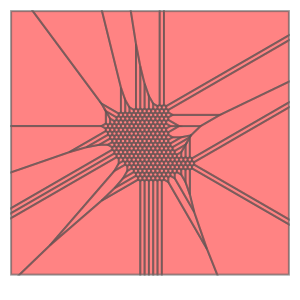

In [95]:
voronoi = shp.voronoi_polygons(tri.unary_union)
voronoi # it is a geometrycollection at this point

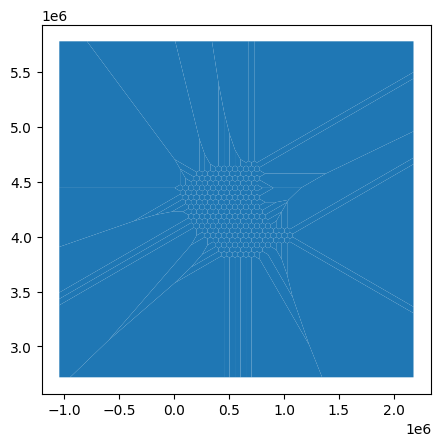

In [96]:
voronoi_df = gpd.GeoDataFrame(geometry=[voronoi])  # [voronoi] is a list
voronoi_df["geometries"] = voronoi_df.apply(lambda row: [g for g in row.geometry.geoms], axis=1)
voronoi_df.plot();

Notice the coordinate match our layer's CRS. But to this point, Shapely's Voronoi output is considered "naive geometry", though it is now encapsulated in a GeoDataFrame. We thus need to declare explicitly its refercence system. You'd also need to specify *inplace=True* so that the declaration is effectively implemented on the GeoDataFrame.

In [97]:
voronoi_df.drop(columns='geometries', inplace=True)
voronoi_df.set_crs(layer.crs, inplace=True)

,geometry
0,GEOMETRYCOLLECTION (POLYGON ((54011.353 447249...


### Exploding this multipolygon into as many polygons

I want as many rows in my GeoDataFrame as there are cells in the geometry. [Explode() method](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explode.html) is the cure.

The method does preserve CRS declaration, hence no need to declare a CRS there. CRS mismatch can indeed cause issues with GeoPanda's [clipping method](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html#geopandas.clip).

In [98]:
exploded_df = voronoi_df.explode(index_parts=True)
exploded_df.columns  # TEST

Index(['geometry'], dtype='object')

## Trimming

### Polygon Clipping

If I kept cells that are on top of coastal area without [clipping](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html#geopandas.clip) them to the shore line, I'd have erroneous numbers in my spatial interpolation since there would be no way to differentiate the "NO DATA" part ouf our study -missing or unreliable figures- with the "NO DATA" as data that is outside of the studied area.

In [99]:
hex_clip = gpd.clip(gdf=exploded_df, mask=layer, keep_geom_type=False)
hex_clip.head()   # TEST

geometry
0 140  MULTIPOLYGON (((500985.413 3864534.026, 501038...
  149  MULTIPOLYGON (((504011.353 3895148.566, 529011...
  128  MULTIPOLYGON (((479011.353 3909582.323, 498743...
  117  MULTIPOLYGON (((479011.353 3938449.837, 479011...
  139  MULTIPOLYGON (((499620.879 3897683.408, 499556...

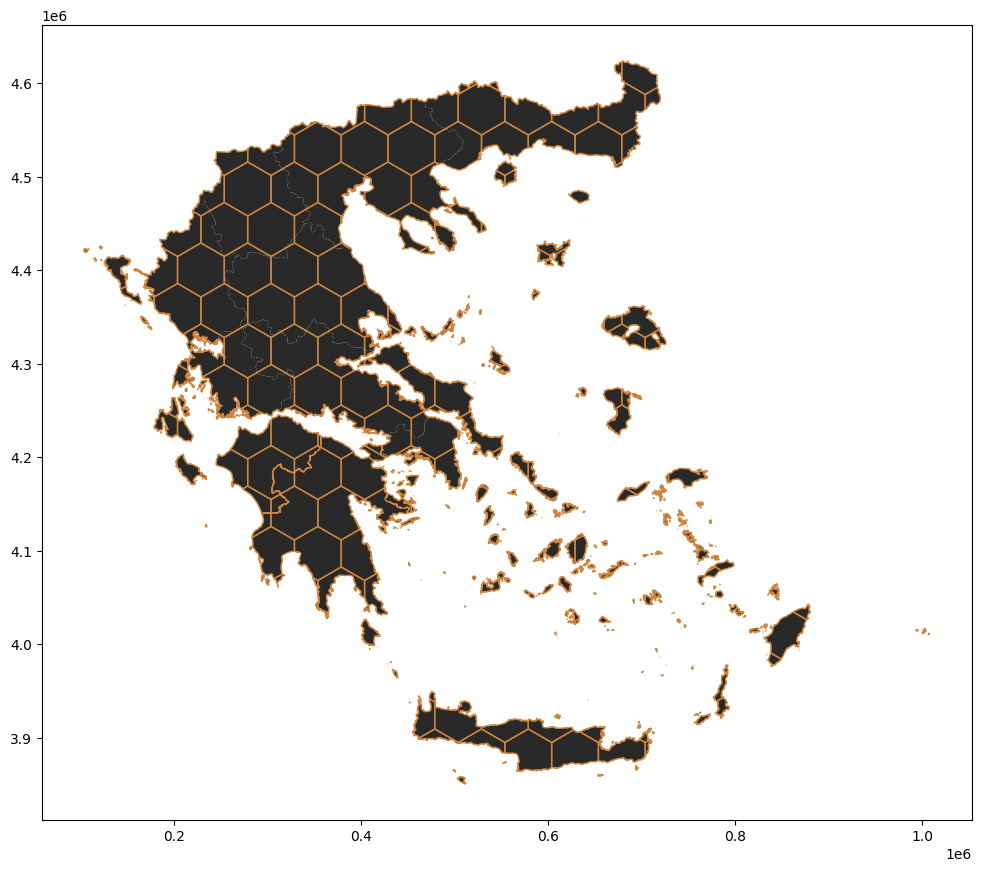

In [100]:
basemap = layer.plot(figsize=(12,12), facecolor=(0.16,0.16,0.16), zorder=1)
# basemap = tri.plot(ax=basemap, facecolor='slategrey',alpha = 0.5, zorder=3)
hex_clip.plot(ax=basemap, facecolor='none', ec='peru', zorder=2);

## Un-buffered greece: Creating a bounding box geodataframe


from a bit of help from the [envelope](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.envelope.html) which returns a geoseries.In turn this allows us to creating a [geodataframe](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html).


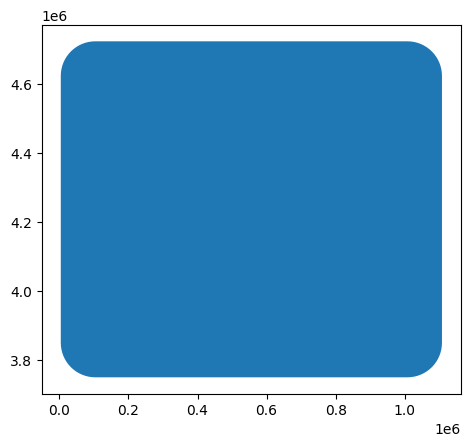

In [101]:
layer_envelope = layer.unary_union.envelope.buffer(buffer_dist)
# layer_envelope # TEST
layer_envelope_df = gpd.GeoDataFrame(geometry=[layer_envelope], crs=layer.crs)
layer_envelope_df.plot();

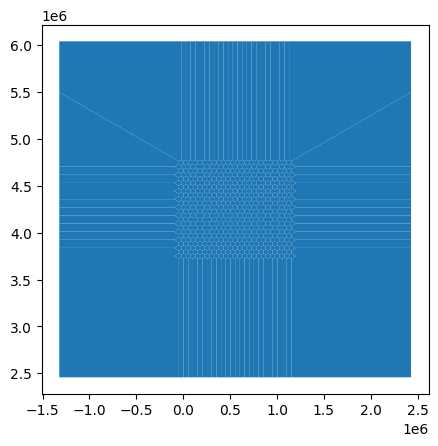

In [102]:
voronoi_andevens = shp.voronoi_polygons(oddsandevens.unary_union)  # don't buffer here

voronoi_andevens  # it is a geometrycollection at this point
voronoi_andevens_df = gpd.GeoDataFrame(geometry=[voronoi_andevens])  # [voronoi] is a list
voronoi_andevens_df["geometries"] = voronoi_andevens_df.apply(lambda row: [g for g in row.geometry.geoms], axis=1)
voronoi_andevens_df.plot();

In [103]:
voronoi_andevens_df.columns

Index(['geometry', 'geometries'], dtype='object')

In [104]:
# voronoi_andevens_df.drop(columns='geometries', inplace=True)
voronoi_andevens_df.set_crs(layer.crs, inplace=True)
exploded_andevens_df = voronoi_andevens_df.explode(index_parts=True)
exploded_andevens_df.head()


geometries  \
0 0  [POLYGON ((-45988.647187009265 3808546.0261060...   
  1  [POLYGON ((-45988.647187009265 3808546.0261060...   
  2  [POLYGON ((-45988.647187009265 3808546.0261060...   
  3  [POLYGON ((-45988.647187009265 3808546.0261060...   
  4  [POLYGON ((-45988.647187009265 3808546.0261060...   

                                              geometry  
0 0  POLYGON ((-45988.647 3808546.026, -95988.647 3...  
  1  POLYGON ((-1320988.647 3837413.540, -95988.647...  
  2  POLYGON ((-1320988.647 2457509.729, -1320988.6...  
  3  POLYGON ((-45988.647 2457509.729, -45988.647 3...  
  4  POLYGON ((-1320988.647 3924016.080, -95988.647...

In [105]:
#clipping
exploded_andevens_clip = gpd.clip(gdf=exploded_andevens_df, mask=layer_envelope_df, keep_geom_type=False)

In [106]:
exploded_andevens_clip_df = gpd.GeoDataFrame(data=exploded_andevens_clip, crs=layer.crs)
exploded_andevens_clip_df

geometries  \
0 68   [POLYGON ((-45988.647187009265 3808546.0261060...   
  54   [POLYGON ((-45988.647187009265 3808546.0261060...   
  67   [POLYGON ((-45988.647187009265 3808546.0261060...   
  146  [POLYGON ((-45988.647187009265 3808546.0261060...   
  120  [POLYGON ((-45988.647187009265 3808546.0261060...   
...                                                  ...   
  608  [POLYGON ((-45988.647187009265 3808546.0261060...   
  597  [POLYGON ((-45988.647187009265 3808546.0261060...   
  623  [POLYGON ((-45988.647187009265 3808546.0261060...   
  479  [POLYGON ((-45988.647187009265 3808546.0261060...   
  557  [POLYGON ((-45988.647187009265 3808546.0261060...   

                                                geometry  
0 68   POLYGON ((54011.353 3779678.513, 79011.353 376...  
  54   POLYGON ((29011.353 3822979.783, 54011.353 380...  
  67   POLYGON ((29011.353 3822979.783, 29011.353 385...  
  146  POLYGON ((179011.353 3765244.756, 204011.353 3...  
  120  POLYGON ((129011.353 3765244.756, 154011.353 3...  
...                                                  ...  
  608  POLYGON ((1054011.353 4674571.430, 1079011.353...  
  597  POLYGON ((1029011.353 4717872.700, 1033514.760...  
  623  POLYGON ((1079011.353 4694223.285, 1085237.468...  
  479  POLYGON ((829011.353 4717872.700, 818546.653 4...  
  557  POLYGON ((979011.353 4717872.700, 968546.653 4...  

[555 rows x 2 columns]

In [107]:
# selection by localisation
exploded_andevens_select = gpd.sjoin(exploded_andevens_df, layer_envelope_df, predicate='intersects', how='inner')
exploded_andevens_select.drop(columns='index_right', inplace=True)  #grooming

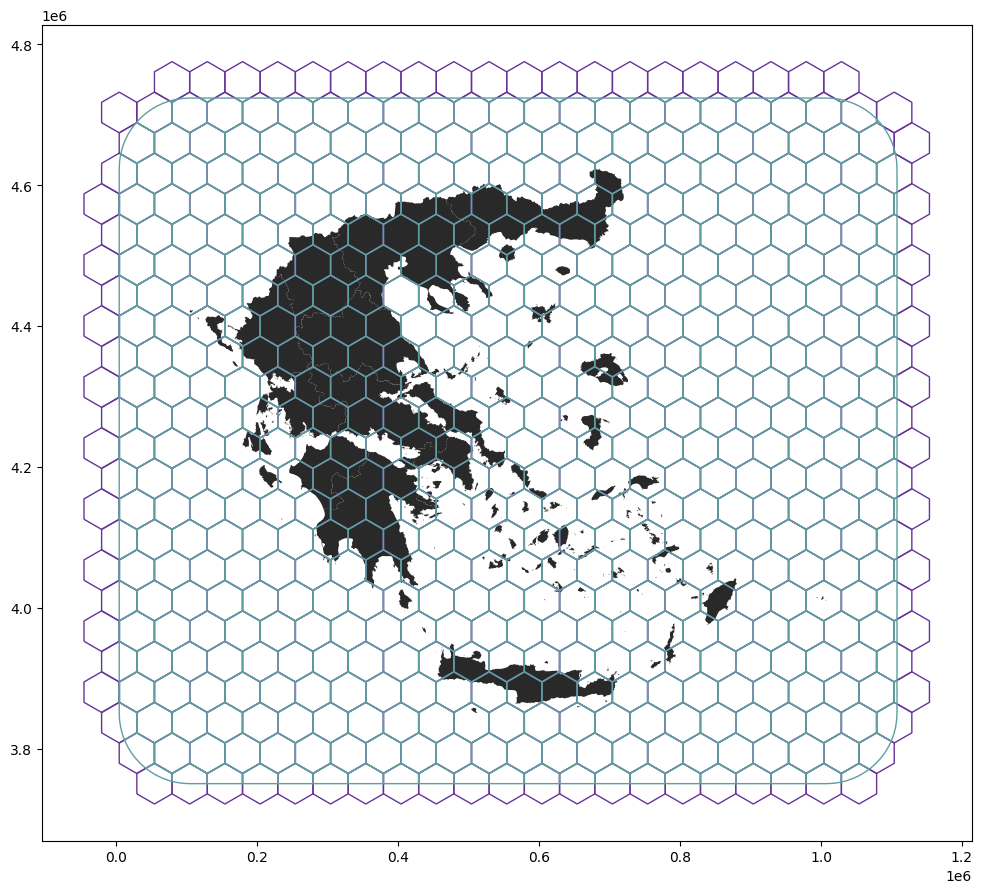

In [108]:
basemap = layer.plot(figsize=(12,12), facecolor=(0.16,0.16,0.16), zorder=1)
exploded_andevens_clip.plot(ax=basemap,facecolor='none', ec='cadetblue', zorder=3)
exploded_andevens_select.plot(ax=basemap,facecolor='none', ec='rebeccapurple', zorder=2);

### Export to Shapefile : make all of these guys a multipolygon

Notice we make are reusing our *a* parameter to name our file. I'm replacing files with the same name. These combined conventions are allowing me to run th script over and over without flooding my database and keep different scaled data in my database.

In [109]:
hex_clip['geometry']

0  140    MULTIPOLYGON (((500985.413 3864534.026, 501038...
   149    MULTIPOLYGON (((504011.353 3895148.566, 529011...
   128    MULTIPOLYGON (((479011.353 3909582.323, 498743...
   117    MULTIPOLYGON (((479011.353 3938449.837, 479011...
   139    MULTIPOLYGON (((499620.879 3897683.408, 499556...
                                ...                        
   137    POLYGON ((454011.353 4583508.846, 454185.839 4...
   115    POLYGON ((404011.353 4576705.600, 404013.189 4...
   148    MULTIPOLYGON (((504011.353 4587968.890, 502161...
   42     POLYGON ((254011.353 4501366.349, 254011.353 4...
   51     POLYGON ((279011.353 4515800.106, 254011.353 4...
Name: geometry, Length: 174, dtype: geometry

In [110]:
hex_clip_df = hex_clip['geometry'].explode(index_parts=True)


In [111]:
# creating an index

In [112]:
# importing to Shapefile
hex_clip['geometry'].to_file("hex_clip_{}.shp".format(a))
# hex_clip['geometry'].to_file("hex_clip_10000.shp")

## Sources

J'ai téléchargé un [shapefile](https://geodata.gov.gr/en/dataset/periphereies-elladas/resource/7c80a2c1-93b7-4814-9fc4-245e775acaa6) des régions administratives du site [GEODATA.gov.gr](GEODATA.gov.gr). Projection 2100, que ne lit pas QGIS. J'ai vérifié le décalage avec la carte du monde livrée avec QGIS (si on tape WORLD dans les coordonnées).